# Predicting Fetal Heart Rate Patterns and Fetal States from Cardiotocography Data

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn import svm, metrics, tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
import plotly.express as px
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt

## Import data

From the data documentation:

Attribute Information:

LB - FHR baseline (beats per minute)

AC - # of accelerations per second

FM - # of fetal movements per second

UC - # of uterine contractions per second

DL - # of light decelerations per second

DS - # of severe decelerations per second

DP - # of prolongued decelerations per second

ASTV - percentage of time with abnormal short term variability

MSTV - mean value of short term variability

ALTV - percentage of time with abnormal long term variability

MLTV - mean value of long term variability

Width - width of FHR histogram

Min - minimum of FHR histogram

Max - Maximum of FHR histogram

Nmax - # of histogram peaks

Nzeros - # of histogram zeros

Mode - histogram mode

Mean - histogram mean

Median - histogram median

Variance - histogram variance

Tendency - histogram tendency

A - calm sleep

B - REM sleep

C - calm vigilance

D - active vigilance

SH - shift pattern (A or Susp with shifts)

AD - accelerative/decelerative pattern (stress situation)

DE - decelerative pattern (vagal stimulation)

LD - largely decelerative pattern

FS - flat-sinusoidal pattern (pathological state)

SUSP - suspect pattern

CLASS - FHR pattern class code (1 to 10) for class A to SUSP

NSP - fetal state class code (1=normal; 2=suspect; 3=pathologic)



In [2]:
ctg_data = pd.read_excel('data/CTG.xls', sheet_name='Data', header=1)

## Data Cleaning

In [3]:
#quick look
ctg_data.head()

b       e   AC   FM   UC   DL   DS   DP   DR  Unnamed: 9  ...    E  \
0  240.0   357.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         NaN  ... -1.0   
1    5.0   632.0  4.0  0.0  4.0  2.0  0.0  0.0  0.0         NaN  ... -1.0   
2  177.0   779.0  2.0  0.0  5.0  2.0  0.0  0.0  0.0         NaN  ... -1.0   
3  411.0  1192.0  2.0  0.0  6.0  2.0  0.0  0.0  0.0         NaN  ... -1.0   
4  533.0  1147.0  4.0  0.0  5.0  0.0  0.0  0.0  0.0         NaN  ... -1.0   

    AD   DE   LD   FS  SUSP  Unnamed: 42  CLASS  Unnamed: 44  NSP  
0 -1.0 -1.0 -1.0  1.0  -1.0          NaN    9.0          NaN  2.0  
1  1.0 -1.0 -1.0 -1.0  -1.0          NaN    6.0          NaN  1.0  
2  1.0 -1.0 -1.0 -1.0  -1.0          NaN    6.0          NaN  1.0  
3  1.0 -1.0 -1.0 -1.0  -1.0          NaN    6.0          NaN  1.0  
4 -1.0 -1.0 -1.0 -1.0  -1.0          NaN    2.0          NaN  1.0  

[5 rows x 46 columns]

In [4]:
ctg_data.tail()

b       e   AC     FM    UC    DL   DS   DP   DR  Unnamed: 9  ...  \
2124  1576.0  3049.0  1.0    0.0   9.0   0.0  0.0  0.0  0.0         NaN  ...   
2125  2796.0  3415.0  1.0    1.0   5.0   0.0  0.0  0.0  0.0         NaN  ...   
2126     NaN     NaN  NaN    NaN   NaN   NaN  NaN  NaN  NaN         NaN  ...   
2127     NaN     NaN  NaN    NaN   NaN   0.0  0.0  0.0  0.0         NaN  ...   
2128     NaN     NaN  NaN  564.0  23.0  16.0  1.0  4.0  0.0         NaN  ...   

         E     AD     DE     LD    FS   SUSP  Unnamed: 42  CLASS  Unnamed: 44  \
2124   1.0   -1.0   -1.0   -1.0  -1.0   -1.0          NaN    5.0          NaN   
2125  -1.0   -1.0   -1.0   -1.0  -1.0   -1.0          NaN    1.0          NaN   
2126   NaN    NaN    NaN    NaN   NaN    NaN          NaN    NaN          NaN   
2127  72.0  332.0  252.0  107.0  69.0  197.0          NaN    NaN          NaN   
2128   NaN    NaN    NaN    NaN   NaN    NaN          NaN    NaN          NaN   

      NSP  
2124  2.0  
2125  1.0  
2126  NaN  
2127  NaN  
2128  NaN  

[5 rows x 46 columns]

In [5]:
ctg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   b            2126 non-null   float64
 1   e            2126 non-null   float64
 2   AC           2126 non-null   float64
 3   FM           2127 non-null   float64
 4   UC           2127 non-null   float64
 5   DL           2128 non-null   float64
 6   DS           2128 non-null   float64
 7   DP           2128 non-null   float64
 8   DR           2128 non-null   float64
 9   Unnamed: 9   0 non-null      float64
 10  LB           2126 non-null   float64
 11  AC.1         2126 non-null   float64
 12  FM.1         2127 non-null   float64
 13  UC.1         2127 non-null   float64
 14  DL.1         2128 non-null   float64
 15  DS.1         2128 non-null   float64
 16  DP.1         2128 non-null   float64
 17  ASTV         2127 non-null   float64
 18  MSTV         2127 non-null   float64
 19  ALTV  

The format of the data left some columns of null values, and there are some trailing rows that are incomplete, these will be dropped.

In [6]:
#drop null columns
ctg_data.dropna(axis=1, how='all', inplace=True)

In [7]:
#drop incomplete rows
ctg_data.dropna(axis=0, inplace=True)

In [8]:
#sanity check
ctg_data.isnull().any().all()

False

There is a set of 6 features that appear twice in the data, they are explored here.

In [9]:
#numerical information of each set of columns
ctg_data[['AC', 'FM', 'UC', 'DL', 'DS', 'DP']].describe()

AC           FM           UC           DL           DS  \
count  2126.000000  2126.000000  2126.000000  2126.000000  2126.000000   
mean      2.722484     7.241298     3.659925     1.570085     0.003293   
std       3.560850    37.125309     2.847094     2.499229     0.057300   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     1.000000     0.000000     0.000000   
50%       1.000000     0.000000     3.000000     0.000000     0.000000   
75%       4.000000     2.000000     5.000000     3.000000     0.000000   
max      26.000000   564.000000    23.000000    16.000000     1.000000   

                DP  
count  2126.000000  
mean      0.126058  
std       0.464361  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       4.000000

In [10]:
ctg_data[['AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1']].describe()

AC.1         FM.1         UC.1         DL.1         DS.1  \
count  2126.000000  2126.000000  2126.000000  2126.000000  2126.000000   
mean      0.003170     0.009474     0.004357     0.001885     0.000004   
std       0.003860     0.046670     0.002940     0.002962     0.000063   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.001876     0.000000     0.000000   
50%       0.001630     0.000000     0.004482     0.000000     0.000000   
75%       0.005631     0.002512     0.006525     0.003264     0.000000   
max       0.019284     0.480634     0.014925     0.015385     0.001353   

              DP.1  
count  2126.000000  
mean      0.000157  
std       0.000580  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       0.005348

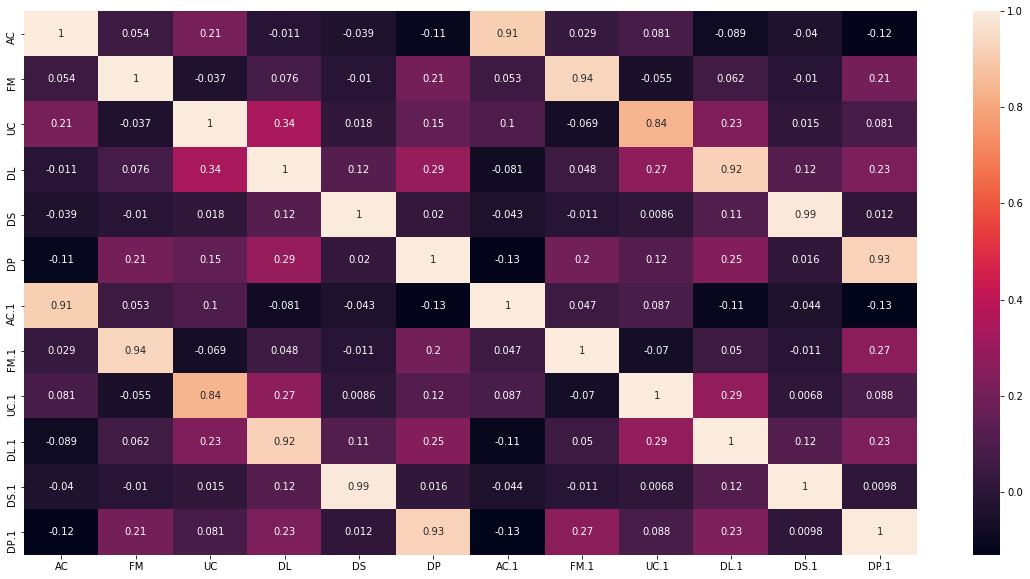

In [11]:
#checking to see if the sister rows are correlated
sis_cols = pd.concat([ctg_data.loc[:,'AC': 'DP'], ctg_data.loc[:,'AC.1':'DP.1']], axis=1)
sis_corr = sis_cols.corr()
plt.figure(figsize=(20,10))
sns.heatmap(sis_corr, annot=True)
plt.show()

In [12]:
#DR column is a column of zeros
ctg_data['DR'].describe()

count    2126.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: DR, dtype: float64

The sister columns are highly correlated, I am pretty sure the features labeled '.1' are transformed versions of the sister columns. What I believe is untransformed data will be dropped. Features 'b' and 'e' will alo be dropped because they are irelevant time data referring to when the cardiotocograph was measured. Finally 'DR' will be dropped since it is a column of zeros and will provide no predictive power. 

In [13]:
#drop columns
ctg_data.drop(labels=['b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR'], axis=1, inplace=True)

The feature 'Tendency', the targets 'CLASS' and 'NSP' and the class atribute variables 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', and 'SUSP' all need to be categorical data. 

In [14]:
#change data to category
ctg_data.loc[:,'Tendency':'NSP'] = ctg_data.loc[:,'Tendency':'NSP'].astype('category')

In [15]:
#drop duplicates, reset index
ctg_data = ctg_data.drop_duplicates().reset_index(drop=True)

## Exploratory Data Analysis

In [16]:
#view of data
ctg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LB        2115 non-null   float64 
 1   AC.1      2115 non-null   float64 
 2   FM.1      2115 non-null   float64 
 3   UC.1      2115 non-null   float64 
 4   DL.1      2115 non-null   float64 
 5   DS.1      2115 non-null   float64 
 6   DP.1      2115 non-null   float64 
 7   ASTV      2115 non-null   float64 
 8   MSTV      2115 non-null   float64 
 9   ALTV      2115 non-null   float64 
 10  MLTV      2115 non-null   float64 
 11  Width     2115 non-null   float64 
 12  Min       2115 non-null   float64 
 13  Max       2115 non-null   float64 
 14  Nmax      2115 non-null   float64 
 15  Nzeros    2115 non-null   float64 
 16  Mode      2115 non-null   float64 
 17  Mean      2115 non-null   float64 
 18  Median    2115 non-null   float64 
 19  Variance  2115 non-null   float64 
 20  Tendency

In [17]:
ctg_data.shape

(2115, 33)

In [18]:
#numeric data
ctg_data.loc[:,'LB':'MLTV'].describe()

LB         AC.1         FM.1         UC.1         DL.1  \
count  2115.000000  2115.000000  2115.000000  2115.000000  2115.000000   
mean    133.301655     0.003178     0.009501     0.004375     0.001894   
std       9.836399     0.003864     0.046787     0.002935     0.002967   
min     106.000000     0.000000     0.000000     0.000000     0.000000   
25%     126.000000     0.000000     0.000000     0.001919     0.000000   
50%     133.000000     0.001637     0.000000     0.004505     0.000000   
75%     140.000000     0.005650     0.002502     0.006536     0.003283   
max     160.000000     0.019284     0.480634     0.014925     0.015385   

              DS.1         DP.1         ASTV         MSTV         ALTV  \
count  2115.000000  2115.000000  2115.000000  2115.000000  2115.000000   
mean      0.000004     0.000157    46.977778     1.335035     9.789598   
std       0.000063     0.000581    17.180933     0.884111    18.329675   
min       0.000000     0.000000    12.000000     0.200000     0.000000   
25%       0.000000     0.000000    32.000000     0.700000     0.000000   
50%       0.000000     0.000000    49.000000     1.200000     0.000000   
75%       0.000000     0.000000    61.000000     1.700000    11.000000   
max       0.001353     0.005348    87.000000     7.000000    91.000000   

              MLTV  
count  2115.000000  
mean      8.170922  
std       5.632455  
min       0.000000  
25%       4.600000  
50%       7.400000  
75%      10.800000  
max      50.700000

In [19]:
ctg_data.loc[:,'Width':'Variance'].describe()

Width          Min          Max         Nmax       Nzeros  \
count  2115.000000  2115.000000  2115.000000  2115.000000  2115.000000   
mean     70.511111    93.574468   164.085579     4.075650     0.325296   
std      38.997589    29.550040    17.943983     2.951027     0.707507   
min       3.000000    50.000000   122.000000     0.000000     0.000000   
25%      37.000000    67.000000   152.000000     2.000000     0.000000   
50%      68.000000    93.000000   162.000000     4.000000     0.000000   
75%     100.000000   120.000000   174.000000     6.000000     0.000000   
max     180.000000   159.000000   238.000000    18.000000    10.000000   

              Mode         Mean       Median     Variance  
count  2115.000000  2115.000000  2115.000000  2115.000000  
mean    137.448227   134.596217   138.084161    18.891726  
std      16.398956    15.607096    14.476729    29.029413  
min      60.000000    73.000000    77.000000     0.000000  
25%     129.000000   125.000000   129.000000     2.000000  
50%     139.000000   136.000000   139.000000     7.000000  
75%     148.000000   145.000000   148.000000    24.000000  
max     187.000000   182.000000   186.000000   269.000000

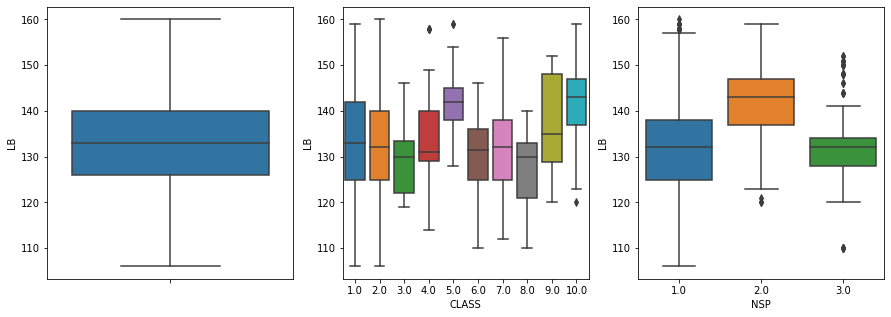

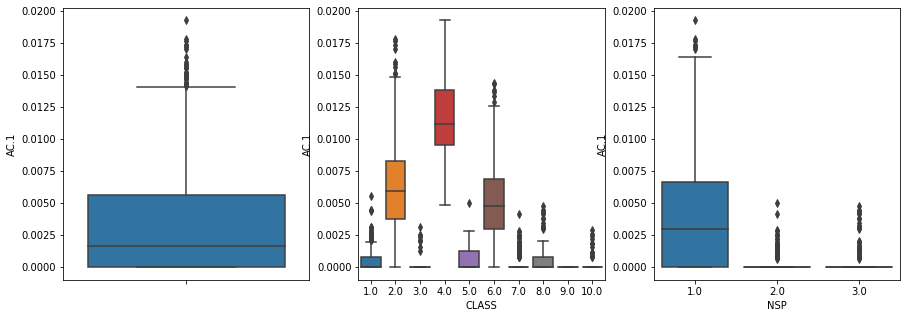

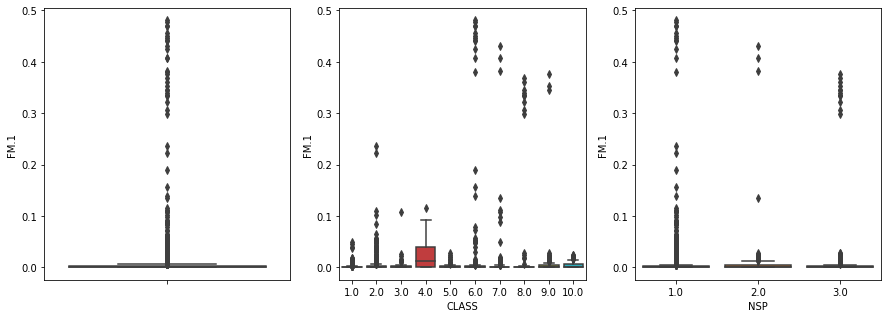

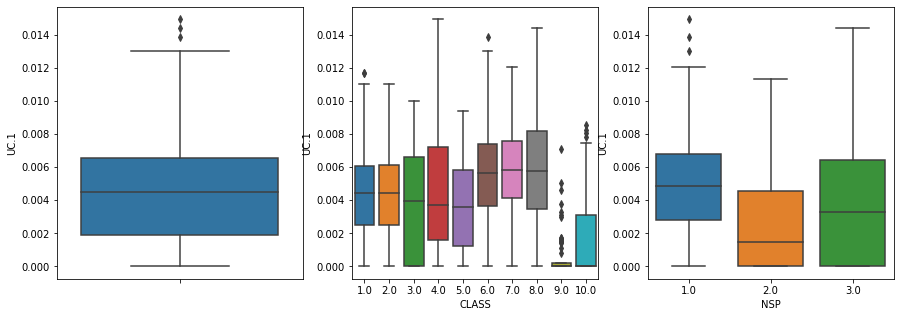

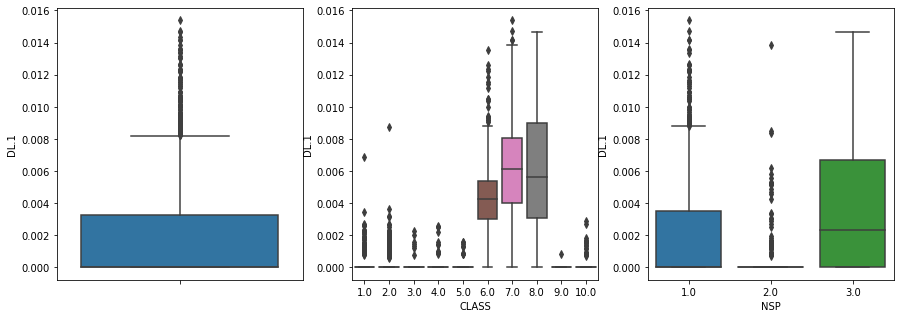

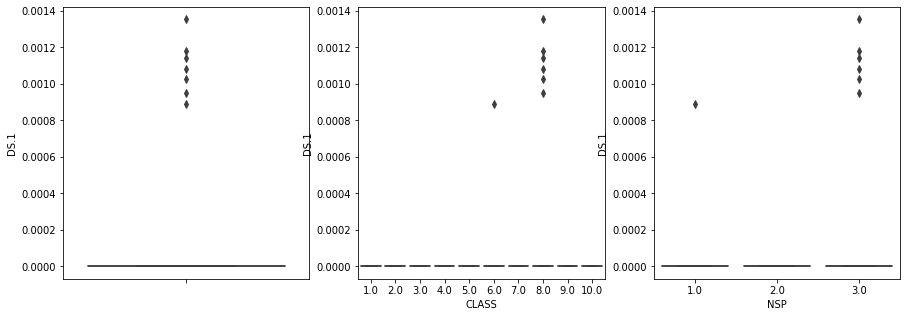

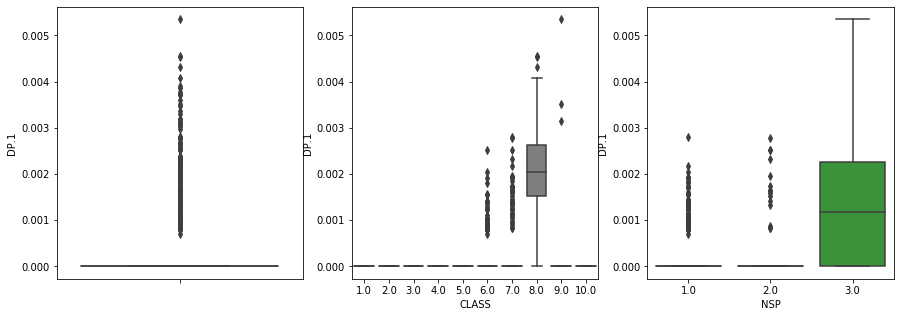

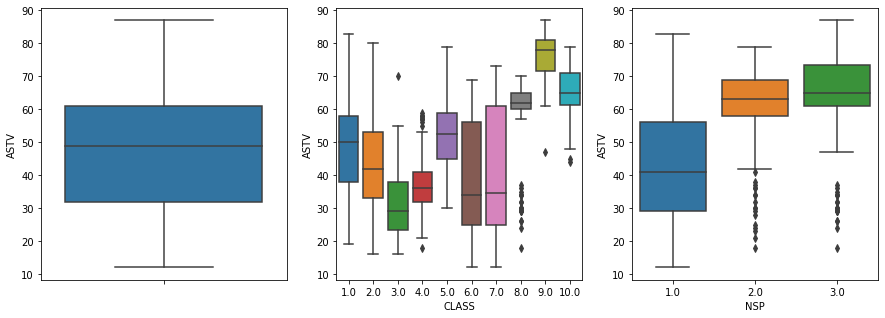

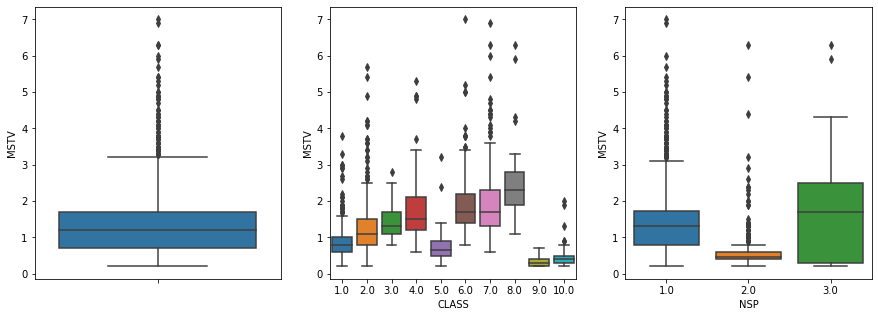

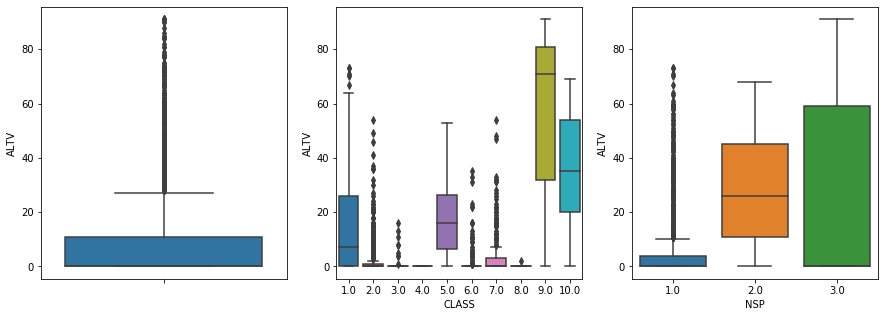

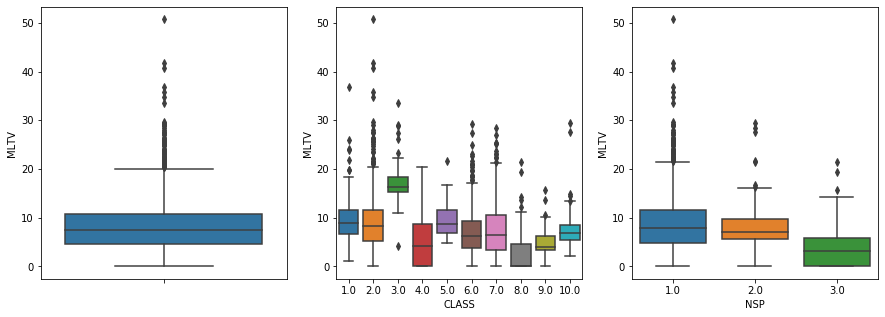

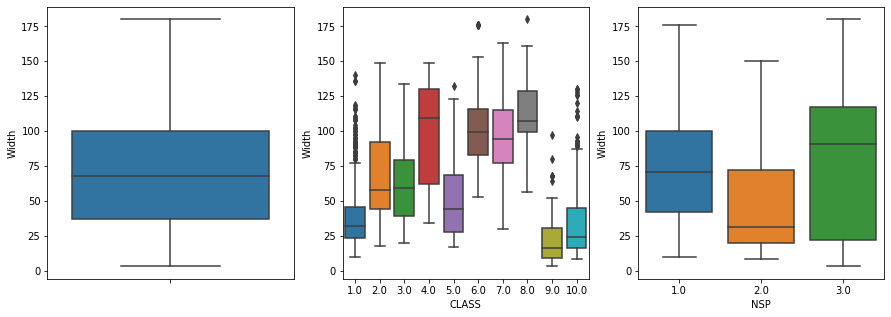

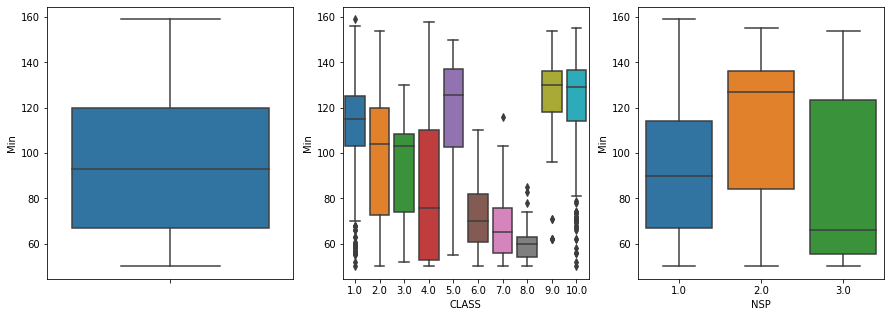

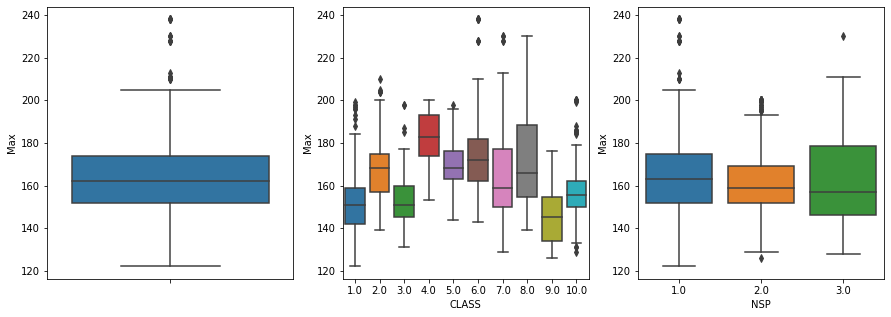

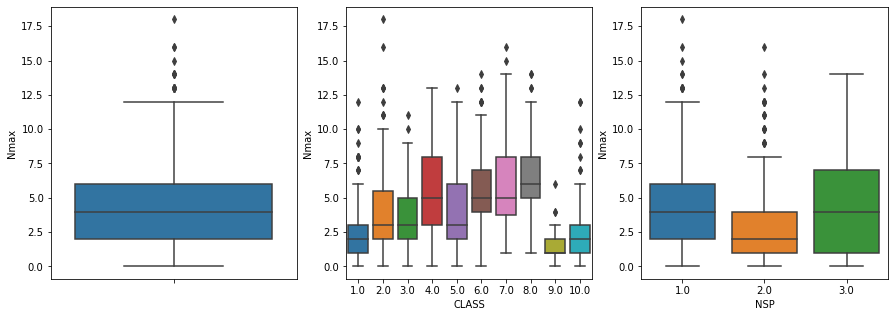

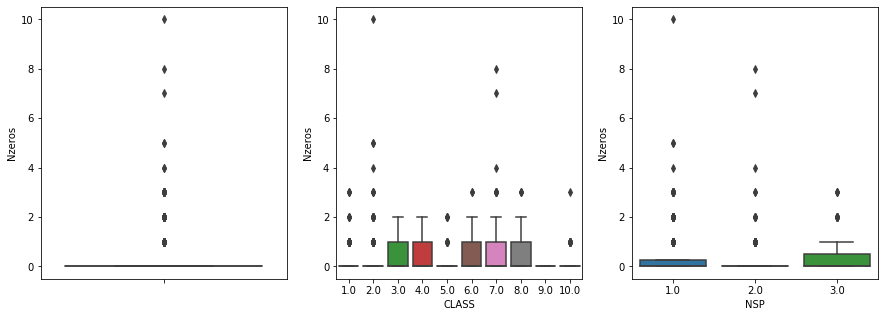

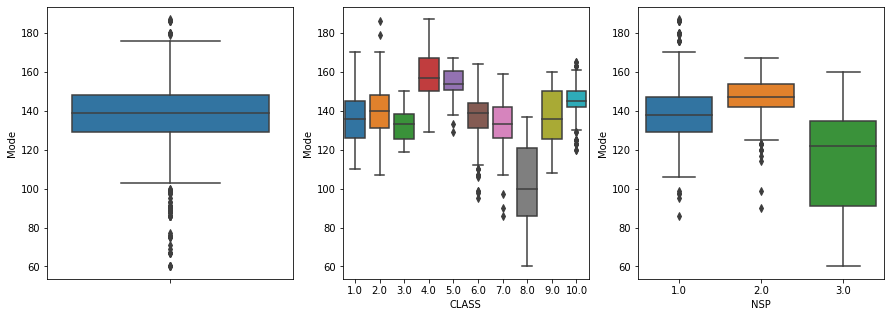

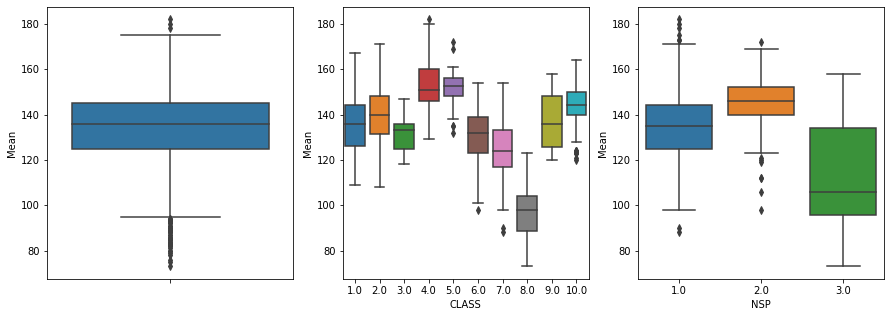

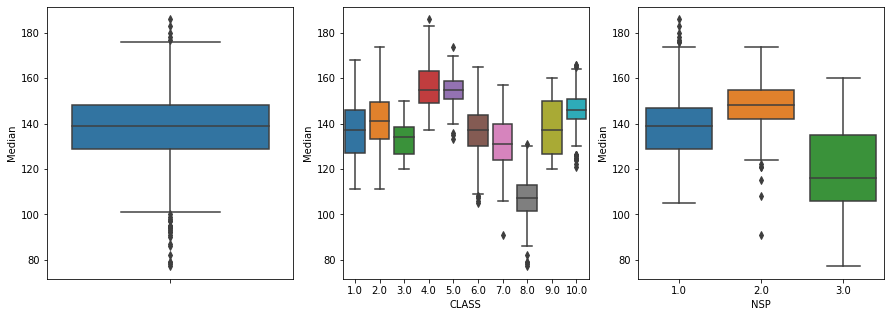

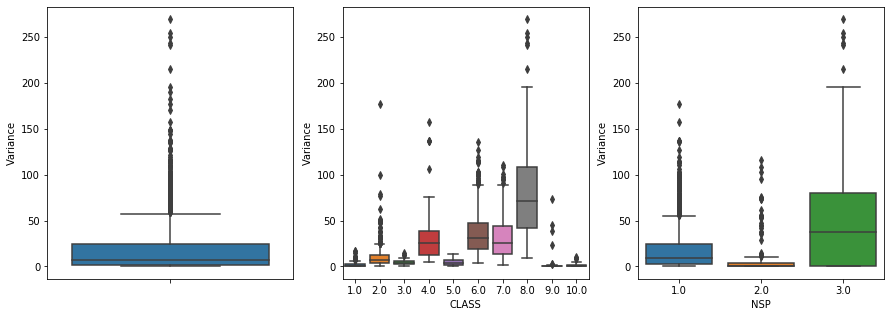

In [20]:
#plot box plots for each feature, boxplots of each class inside of each feature, and boxplots of NSP inside of each feature
for i in ctg_data.columns[0:20]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
    sns.boxplot(ax=ax1, y=ctg_data[i], data=ctg_data)
    sns.boxplot(ax=ax2, x='CLASS', y=ctg_data[i], data=ctg_data)
    sns.boxplot(ax=ax3, x='NSP', y=ctg_data[i], data=ctg_data)
    plt.show()
    plt.close()

The data has a pretty variable range with the smalles feature max equal to .001353, and the largest feature max equal to 160. many features have outliers, some have numerous outliers. I suspect these outliers will be really important in classification.

In [21]:
#scatter matrix of the data to gain a general view. Notice the class grapghs, and how seperated the fetal states are
fig = px.scatter_matrix(ctg_data, 
    dimensions=['LB', 'AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1','CLASS'], color="NSP")
fig.show()
fig = px.scatter_matrix(ctg_data, 
    dimensions=['ASTV', 'MSTV','ALTV', 'MLTV', 'CLASS'], color="NSP")
fig.show()
fig = px.scatter_matrix(ctg_data, 
    dimensions=['Width','Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency','CLASS'], color="NSP")
fig.show()


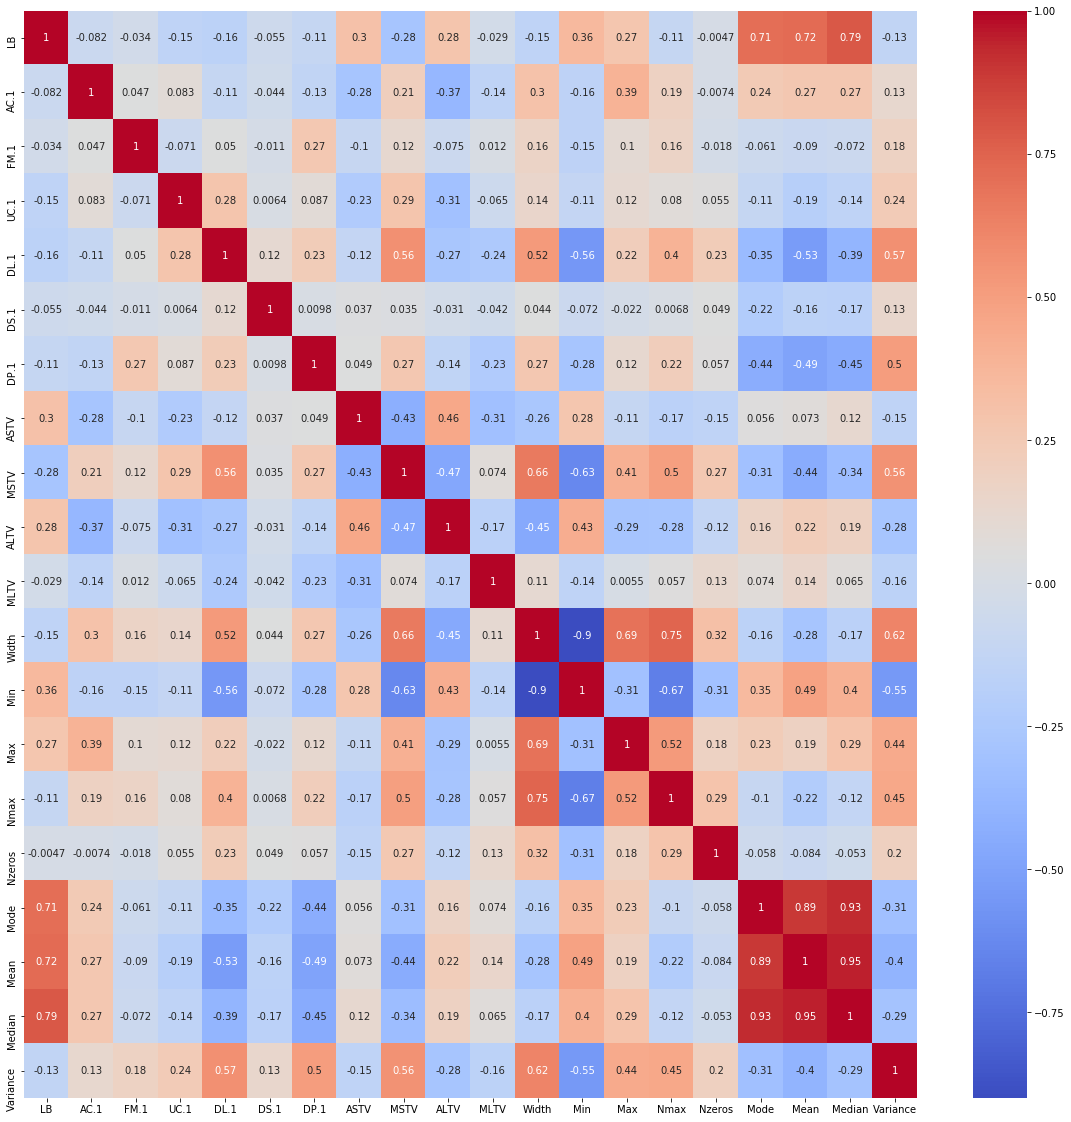

In [22]:
#checking the correlation
corr = ctg_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

There are some pretty clear separations in the data. There are also some pretty strong correlations on the data. A big take away is that NSP is highly segmented in CLASS. Meaning CLASS, a target will heavily influence the predictive power of any model. Due to the high correlation in the data feature elimination will be run in the future.

In [23]:
#data spread across class codes
df1 = ctg_data.groupby(['CLASS']).count()['LB']
df1

CLASS
1.0     383
2.0     575
3.0      51
4.0      81
5.0      72
6.0     332
7.0     252
8.0     107
9.0      68
10.0    194
Name: LB, dtype: int64

In [24]:
#data spread across pathelogical states
df2 = ctg_data.groupby(['NSP']).count()['LB']
df2

NSP
1.0    1648
2.0     292
3.0     175
Name: LB, dtype: int64

In [25]:
#data spread across both pathelogical states and class codes
df3 = ctg_data.groupby(['NSP', 'CLASS']).count()['LB']
df3.dropna(inplace=True)
df3


NSP  CLASS
1.0  1.0      381.0
     2.0      575.0
     3.0       51.0
     4.0       81.0
     5.0        3.0
     6.0      330.0
     7.0      227.0
2.0  1.0        2.0
     5.0       69.0
     6.0        2.0
     7.0       25.0
     9.0        1.0
     10.0     193.0
3.0  8.0      107.0
     9.0       67.0
     10.0       1.0
Name: LB, dtype: float64

The data is fairly imbalanced with approximately 22% of our data being either 2 (suspect) or 3 (pathological) for pathelogic state. The data is also imbalanced in regards to class with some classes having nearly 12 times as many data points as others.

## Modeling
First models predicting NSP with be generated and trained as a baseline, then a model predicting CLASS will be generated and trained. These models will be combined into a chain classifier. These baseline medels will then be compared to data that has had the target imbalance fixed using oversampling of the minority classes and undersampling of the majority class/classes, depending on the target.

In [26]:
#split the data
ctg_data.loc[:,'Tendency':'SUSP'] = ctg_data.loc[:,'Tendency':'SUSP'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(ctg_data.loc[:,'LB':'Tendency'], ctg_data[['CLASS', 'NSP']],
                                                    test_size=0.3, random_state=13,  stratify=ctg_data['NSP'])
y_train_class = y_train['CLASS'].reset_index(drop=True)
y_test_class = y_test['CLASS'].reset_index(drop=True)
y_train_nsp = y_train['NSP'].reset_index(drop=True)
y_test_nsp = y_test['NSP'].reset_index(drop=True)

In [27]:
#scale the data, RobustScaler was used due to the many outliers in parts of the data
rob_scale = RobustScaler()
X_train_scale = rob_scale.fit_transform(X_train, y_train)
X_test_scale = rob_scale.transform(X_test)

### Predict Fetal State for baseline

NSP models
Support Vector Machine:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       495
         2.0       0.68      0.75      0.71        88
         3.0       0.85      0.79      0.82        52

    accuracy                           0.91       635
   macro avg       0.83      0.83      0.83       635
weighted avg       0.91      0.91      0.91       635

confusion matrix 
[[469  23   3]
 [ 18  66   4]
 [  3   8  41]]



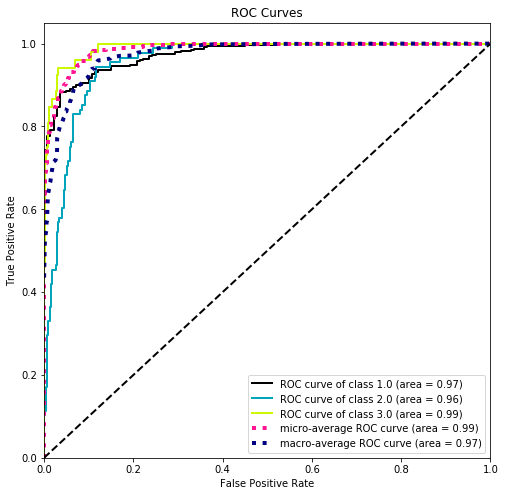

NSP models
Logistic Regression:
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.94       495
         2.0       0.67      0.68      0.67        88
         3.0       0.84      0.79      0.81        52

    accuracy                           0.90       635
   macro avg       0.82      0.81      0.81       635
weighted avg       0.90      0.90      0.90       635

confusion matrix 
[[468  23   4]
 [ 24  60   4]
 [  4   7  41]]



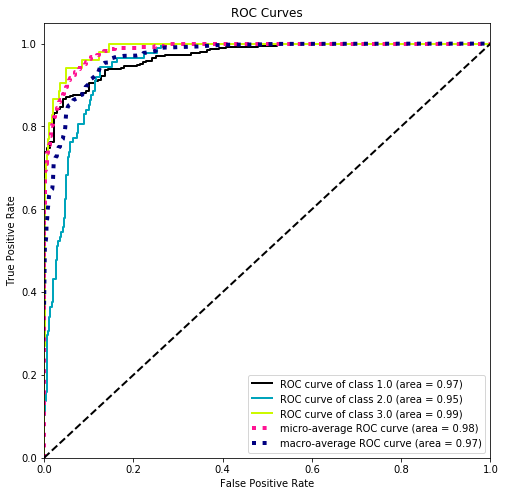

NSP models
K-Nearest Neighbors:
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       495
         2.0       0.74      0.58      0.65        88
         3.0       0.80      0.79      0.80        52

    accuracy                           0.90       635
   macro avg       0.83      0.78      0.80       635
weighted avg       0.89      0.90      0.90       635

confusion matrix 
[[480  12   3]
 [ 30  51   7]
 [  5   6  41]]



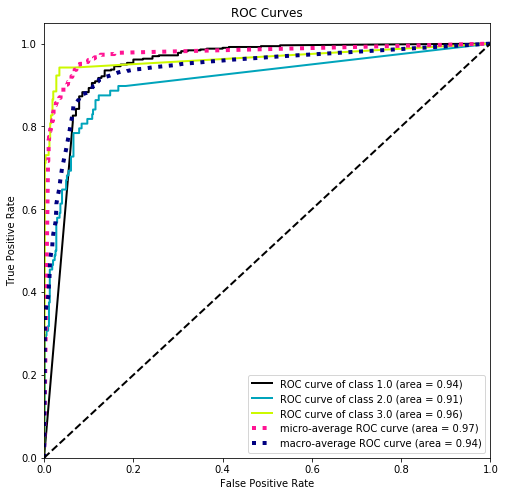

NSP models
Decision Tree:
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96       495
         2.0       0.83      0.77      0.80        88
         3.0       0.91      0.96      0.93        52

    accuracy                           0.94       635
   macro avg       0.90      0.90      0.90       635
weighted avg       0.94      0.94      0.94       635

confusion matrix 
[[479  14   2]
 [ 17  68   3]
 [  2   0  50]]



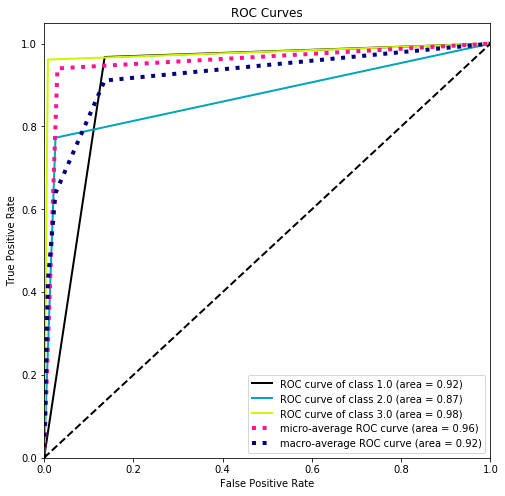

NSP models
Random Forest:
              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       495
         2.0       0.88      0.72      0.79        88
         3.0       0.92      0.88      0.90        52

    accuracy                           0.94       635
   macro avg       0.92      0.86      0.89       635
weighted avg       0.94      0.94      0.94       635

confusion matrix 
[[489   5   1]
 [ 22  63   3]
 [  2   4  46]]



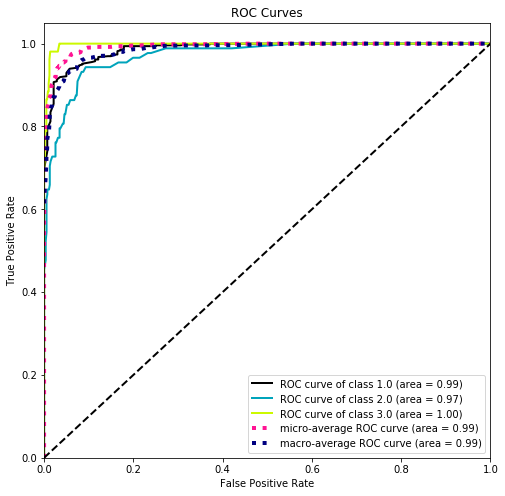

nsp_recall
Support Vector Machine    0.828645
Logistic Regression       0.805245
K-Nearest Neighbors       0.779235
Decision Tree             0.900648
Random Forest             0.862801

In [28]:
#nsp
models = [('Support Vector Machine', svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr', break_ties=True)), 
          ('Logistic Regression', LogisticRegression(solver='newton-cg',n_jobs=-1)), 
          ('K-Nearest Neighbors', KNeighborsClassifier(weights='distance')),
          ('Decision Tree', tree.DecisionTreeClassifier(random_state=13)), 
          ('Random Forest', RandomForestClassifier(random_state=13, n_estimators=100))]
#loops the different models
recall = []
classifiers = []
for clf, model in models:
    classifiers.append(clf)
    model = model
    model.fit(X_train_scale, y_train_nsp)
    y_pred = model.predict(X_test_scale)
    print(f'NSP models\n{clf}:')
    print(classification_report(y_test_nsp, y_pred))
    print(f'confusion matrix \n{confusion_matrix(y_test_nsp, y_pred)}\n')
    recall.append(metrics.recall_score(y_test_nsp, y_pred, average='macro', zero_division=1))
    import scikitplot as skplt
    predicted_probas = model.predict_proba(X_test_scale)
    skplt.metrics.plot_roc(y_test_nsp, predicted_probas, figsize=(8,8))
    plt.show()
    plt.close()
#dataframe for easy viewing    
model_select = pd.DataFrame({'nsp_recall':recall}, index=classifiers)
display(model_select)

Both Decision trees and random forests predict fetal states with good recall. Random Forests have a stronger ROC curve.

### Predict fetal heart rate patterns to generate a chain classifier

Class models
Support Vector Machine:
              precision    recall  f1-score   support

         1.0       0.77      0.83      0.80       115
         2.0       0.88      0.88      0.88       169
         3.0       0.47      0.35      0.40        20
         4.0       0.77      0.71      0.74        24
         5.0       0.67      0.58      0.62        24
         6.0       0.87      0.87      0.87       102
         7.0       0.89      0.90      0.90        73
         8.0       0.97      0.94      0.96        34
         9.0       0.92      0.65      0.76        17
        10.0       0.70      0.75      0.73        57

    accuracy                           0.83       635
   macro avg       0.79      0.75      0.77       635
weighted avg       0.82      0.83      0.82       635

confusion matrix 
[[ 96   2   2   0   3   1   2   0   0   9]
 [  3 149   4   4   1   8   0   0   0   0]
 [ 11   2   7   0   0   0   0   0   0   0]
 [  0   7   0  17   0   0   0   0   0   0]
 [  3   3   0 

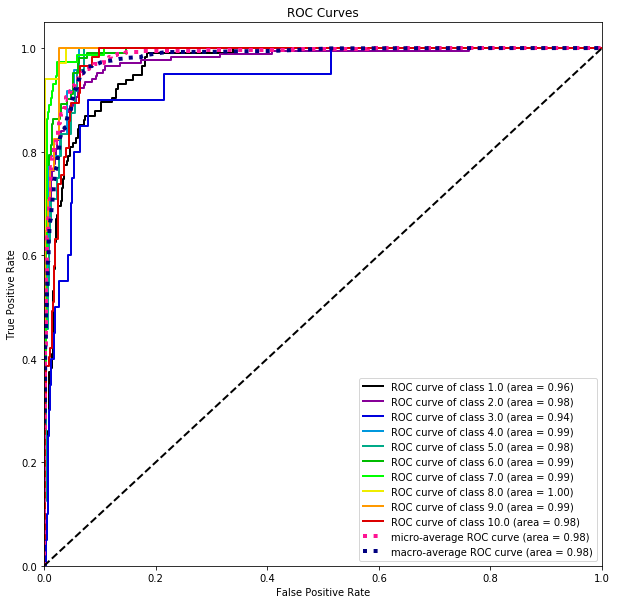

Class models
Logistic Regression:
              precision    recall  f1-score   support

         1.0       0.76      0.79      0.77       115
         2.0       0.86      0.89      0.87       169
         3.0       0.40      0.30      0.34        20
         4.0       0.79      0.62      0.70        24
         5.0       0.71      0.50      0.59        24
         6.0       0.89      0.89      0.89       102
         7.0       0.89      0.90      0.90        73
         8.0       0.94      0.91      0.93        34
         9.0       0.83      0.59      0.69        17
        10.0       0.65      0.79      0.71        57

    accuracy                           0.81       635
   macro avg       0.77      0.72      0.74       635
weighted avg       0.81      0.81      0.81       635

confusion matrix 
[[ 91   4   2   0   2   0   3   0   1  12]
 [  4 150   4   3   2   6   0   0   0   0]
 [ 12   2   6   0   0   0   0   0   0   0]
 [  0   9   0  15   0   0   0   0   0   0]
 [  3   3   0   0

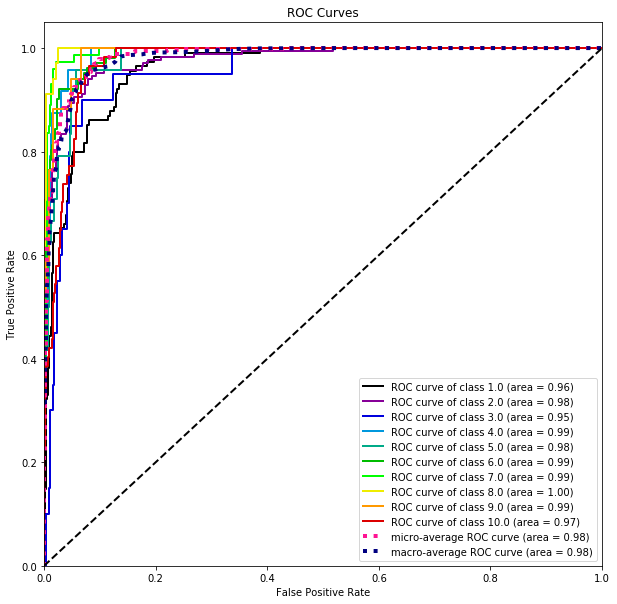

Class models
K-Nearest Neighbors:
              precision    recall  f1-score   support

         1.0       0.69      0.82      0.75       115
         2.0       0.78      0.86      0.82       169
         3.0       0.45      0.25      0.32        20
         4.0       0.88      0.58      0.70        24
         5.0       0.70      0.29      0.41        24
         6.0       0.82      0.75      0.79       102
         7.0       0.78      0.77      0.77        73
         8.0       0.88      0.85      0.87        34
         9.0       0.65      0.65      0.65        17
        10.0       0.72      0.75      0.74        57

    accuracy                           0.76       635
   macro avg       0.73      0.66      0.68       635
weighted avg       0.76      0.76      0.75       635

confusion matrix 
[[ 94   9   3   0   1   0   0   0   0   8]
 [ 13 145   2   2   1   6   0   0   0   0]
 [  9   5   5   0   0   0   1   0   0   0]
 [  0   9   0  14   0   1   0   0   0   0]
 [  5   7   0   0

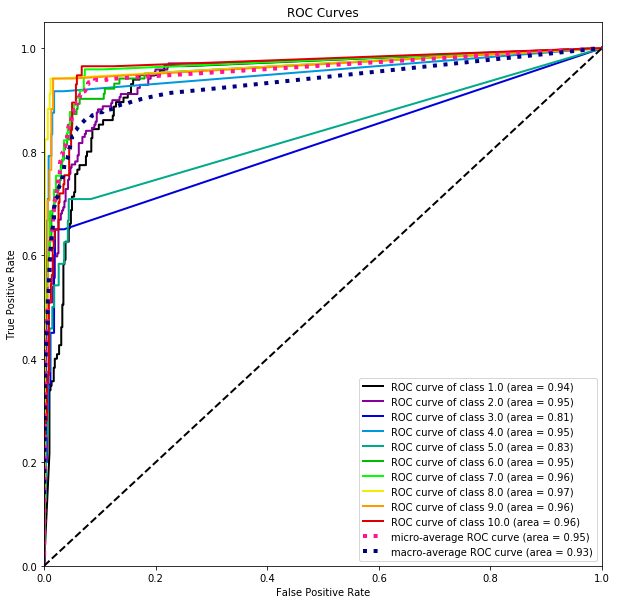

Class models
Decision Tree:
              precision    recall  f1-score   support

         1.0       0.75      0.87      0.80       115
         2.0       0.86      0.86      0.86       169
         3.0       0.71      0.50      0.59        20
         4.0       0.62      0.62      0.62        24
         5.0       0.64      0.38      0.47        24
         6.0       0.87      0.88      0.88       102
         7.0       0.86      0.85      0.86        73
         8.0       0.94      0.88      0.91        34
         9.0       0.76      0.94      0.84        17
        10.0       0.88      0.81      0.84        57

    accuracy                           0.82       635
   macro avg       0.79      0.76      0.77       635
weighted avg       0.82      0.82      0.82       635

confusion matrix 
[[100   4   2   0   3   0   4   1   1   0]
 [  7 145   0   9   1   6   0   0   0   1]
 [  6   3  10   0   0   0   0   0   0   1]
 [  0   8   0  15   0   1   0   0   0   0]
 [  7   1   2   0   9  

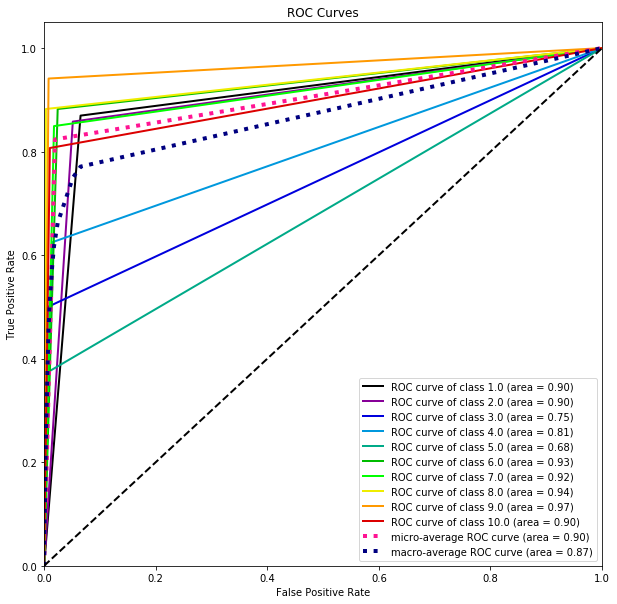

Class models
Random Forest:
              precision    recall  f1-score   support

         1.0       0.85      0.92      0.88       115
         2.0       0.83      0.92      0.88       169
         3.0       0.89      0.40      0.55        20
         4.0       0.79      0.62      0.70        24
         5.0       0.88      0.58      0.70        24
         6.0       0.88      0.90      0.89       102
         7.0       0.92      0.90      0.91        73
         8.0       0.97      0.91      0.94        34
         9.0       0.92      0.65      0.76        17
        10.0       0.85      0.88      0.86        57

    accuracy                           0.86       635
   macro avg       0.88      0.77      0.81       635
weighted avg       0.87      0.86      0.86       635

confusion matrix 
[[106   4   1   0   1   0   3   0   0   0]
 [  4 156   0   3   0   6   0   0   0   0]
 [  8   4   8   0   0   0   0   0   0   0]
 [  0   9   0  15   0   0   0   0   0   0]
 [  2   4   0   0  14  

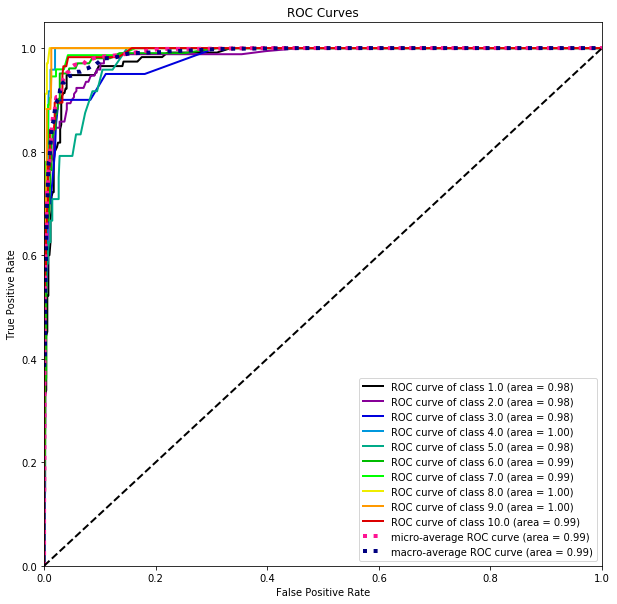

nsp_recall  class_recall
Support Vector Machine    0.828645      0.747739
Logistic Regression       0.805245      0.718962
K-Nearest Neighbors       0.779235      0.657679
Decision Tree             0.900648      0.758977
Random Forest             0.862801      0.769524

In [29]:
#class
models = [('Support Vector Machine', svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr', break_ties=True)), 
          ('Logistic Regression', LogisticRegression(solver='newton-cg',n_jobs=-1)), 
          ('K-Nearest Neighbors', KNeighborsClassifier(weights='distance')),
          ('Decision Tree', tree.DecisionTreeClassifier(random_state=13)), 
          ('Random Forest', RandomForestClassifier(random_state=13, n_estimators=100))]
#loop the different models
recall = []
for clf, model in models:
    model = model
    model.fit(X_train_scale, y_train_class)
    y_pred = model.predict(X_test_scale)
    print(f'Class models\n{clf}:')
    print(classification_report(y_test_class, y_pred))
    print(f'confusion matrix \n{confusion_matrix(y_test_class, y_pred)}\n')
    recall.append(metrics.recall_score(y_test_class, y_pred, average='macro', zero_division=1))
    predicted_probas = model.predict_proba(X_test_scale)
    skplt.metrics.plot_roc(y_test_class, predicted_probas, figsize=(10,10))
    plt.show()
    plt.close()
#dataframe for easy viewing  
model_select['class_recall'] = recall
display(model_select)

Unfortunately none of the models predicted fetal heart rate patterns with great recall, but the random forest classifier does the best job with ~77% recall.

### Generate the chain classifier 
predict the values of CLASS in the test data set, then train models to predict NSP on data that includes actual CLASS values. 

In [30]:
#random forest classifier (best from above)
ctg_rfc1 = RandomForestClassifier(random_state=13, n_estimators=100)
ctg_rfc1.fit(X_train_scale, y_train_class)
y_pred = ctg_rfc1.predict(X_test_scale)


In [31]:
#train the models on the actual class values, but test on predicted class values

#building a Dataframe for training

col = X_train.columns
dummy_col = ctg_data.loc[:,'LB':"SUSP"].columns

#the actual 'CLASS' values are not used in the test set instead predicted values are generated using the model that
#best predicted the 'CLASS' (Random Forest)


X_train2_scale = pd.DataFrame(X_train_scale, columns=col)
X_test2_scale = pd.DataFrame(X_test_scale, columns=col)
train_class = y_train_class
test_class = y_pred
#The data has their dummy variable as '-1' for 'no' and '1' for yes, swapping to '0' for no for consistency
train_dummies = pd.get_dummies(train_class).rename(columns={1.0:'A', 2.0:'B', 3.0:'C', 4.0:'D', 5.0:'E', 6.0:'AD',
                                                                 7.0:'DE', 8.0:'LD', 9.0:'FS', 10.0:'SUSP'})
test_dummies = pd.get_dummies(test_class).rename(columns={1.0:'A', 2.0:'B', 3.0:'C', 4.0:'D', 5.0:'E', 6.0:'AD',
                                                                 7.0:'DE', 8.0:'LD', 9.0:'FS', 10.0:'SUSP'})
X_train2_scale = pd.concat([X_train2_scale, train_dummies], axis=1)
X_train2_scale = X_train2_scale[dummy_col]
X_test2_scale = pd.concat([X_test2_scale, test_dummies], axis=1)
X_test2_scale = X_test2_scale[dummy_col]


### Chain Classifier

Support Vector Machine:
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       495
         2.0       0.89      0.81      0.85        88
         3.0       0.95      0.81      0.88        52

    accuracy                           0.95       635
   macro avg       0.93      0.87      0.90       635
weighted avg       0.95      0.95      0.95       635

confusion matrix 
[[492   2   1]
 [ 16  71   1]
 [  3   7  42]]



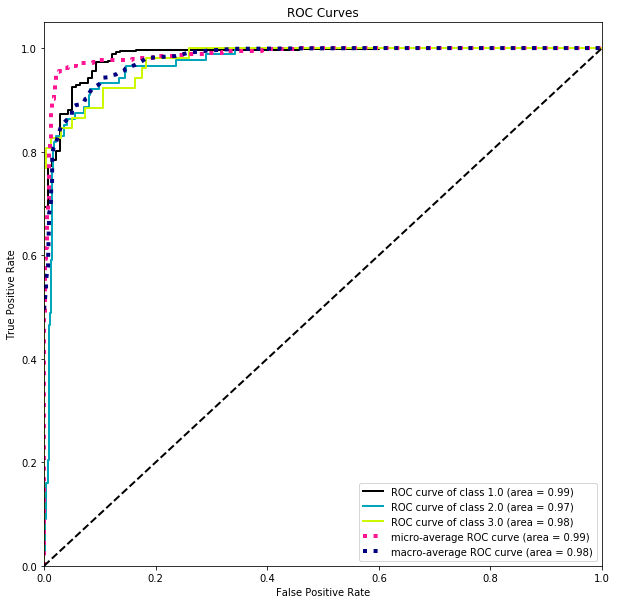

Logistic Regression:
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       495
         2.0       0.88      0.81      0.84        88
         3.0       0.95      0.81      0.88        52

    accuracy                           0.95       635
   macro avg       0.93      0.87      0.90       635
weighted avg       0.95      0.95      0.95       635

confusion matrix 
[[491   3   1]
 [ 16  71   1]
 [  3   7  42]]



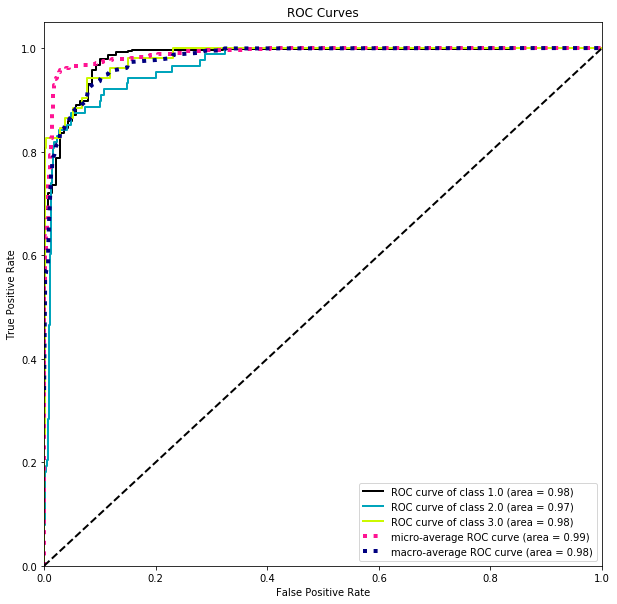

K-Nearest Neighbors:
              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       495
         2.0       0.84      0.73      0.78        88
         3.0       0.95      0.81      0.88        52

    accuracy                           0.94       635
   macro avg       0.92      0.84      0.87       635
weighted avg       0.94      0.94      0.93       635

confusion matrix 
[[489   5   1]
 [ 23  64   1]
 [  3   7  42]]



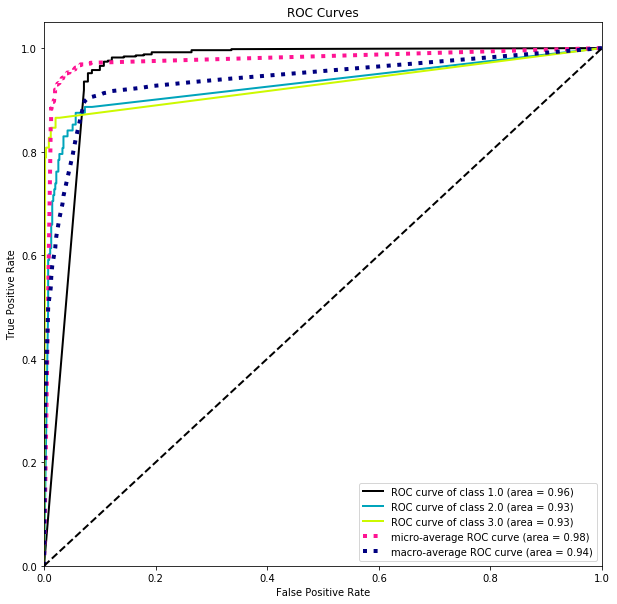

Decision Tree:
              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       495
         2.0       0.83      0.77      0.80        88
         3.0       0.95      0.81      0.88        52

    accuracy                           0.94       635
   macro avg       0.91      0.85      0.88       635
weighted avg       0.94      0.94      0.94       635

confusion matrix 
[[487   7   1]
 [ 19  68   1]
 [  3   7  42]]



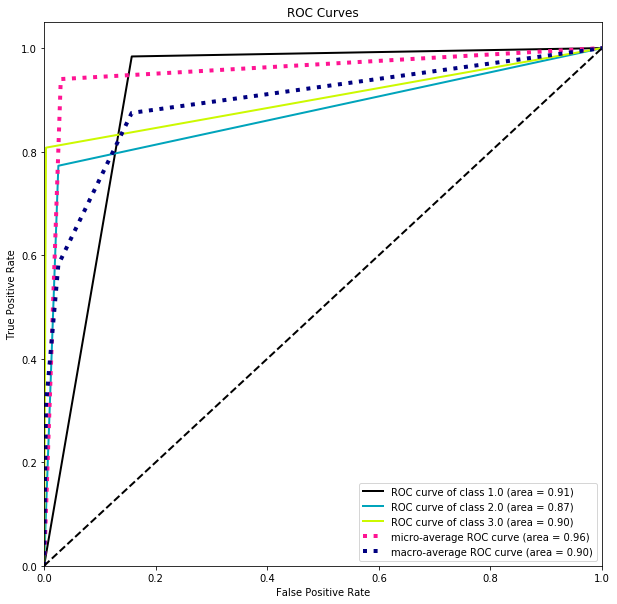

Random Forest:
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       495
         2.0       0.89      0.81      0.85        88
         3.0       0.95      0.81      0.88        52

    accuracy                           0.95       635
   macro avg       0.93      0.87      0.90       635
weighted avg       0.95      0.95      0.95       635

confusion matrix 
[[491   3   1]
 [ 16  71   1]
 [  4   6  42]]



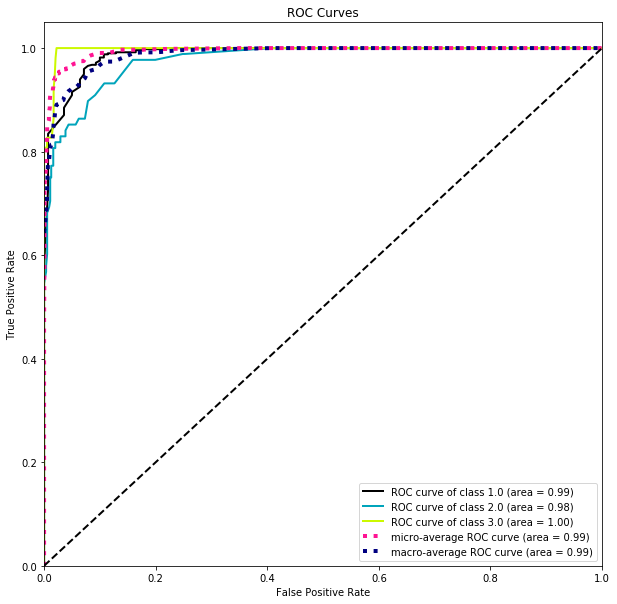

nsp_recall  class_recall  chain_recall
Support Vector Machine    0.828645      0.747739      0.869483
Logistic Regression       0.805245      0.718962      0.868810
K-Nearest Neighbors       0.779235      0.657679      0.840948
Decision Tree             0.900648      0.758977      0.854753
Random Forest             0.862801      0.769524      0.868810

In [32]:
#chain
models = [('Support Vector Machine', svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr', break_ties=True)), 
          ('Logistic Regression', LogisticRegression(solver='newton-cg',n_jobs=-1)), 
          ('K-Nearest Neighbors', KNeighborsClassifier(weights='distance')),
          ('Decision Tree', tree.DecisionTreeClassifier(random_state=13)), 
          ('Random Forest', RandomForestClassifier(random_state=13, n_estimators=100))]

#loop the different models
recall = []
classifiers = []
for clf, model in models:
    model = model
    model.fit(X_train2_scale, y_train_nsp)
    y_pred = model.predict(X_test2_scale)
    print(clf + ':')
    print(classification_report(y_test_nsp, y_pred))
    print(f'confusion matrix \n{confusion_matrix(y_test_nsp, y_pred)}\n')
    recall.append(metrics.recall_score(y_test_nsp, y_pred, average='macro', zero_division=1))
    predicted_probas = model.predict_proba(X_test2_scale)
    skplt.metrics.plot_roc(y_test_nsp, predicted_probas, figsize=(10,10))
    plt.show()
    plt.close()
    
#dataframe for easy viewing  
model_select['chain_recall'] = recall
display(model_select)

The best second classifiers in the chain are SVM's, Logistic Regression, and Random Forests. These three models each had ~87% recall, and strong ROC AUC scores. I hope to improve this accuracy further by oversampling and undersampling the data to improve target imbalances,  and feature selection.

### Model Tuning and Cross Validation
To improve model recall, I attempt to use oversampling and undersampling, cross validation, feature elimination and hyperparameter tuning.

In [33]:
#Target distribution in training set
X = pd.concat([X_train, y_train], axis=1)
display(X.groupby('NSP').count()['LB'])
display(X.groupby('CLASS').count()['LB'])

NSP
1.0    1153
2.0     204
3.0     123
Name: LB, dtype: int64

CLASS
1.0     268
2.0     406
3.0      31
4.0      57
5.0      48
6.0     230
7.0     179
8.0      73
9.0      51
10.0    137
Name: LB, dtype: int64

In [34]:
#generate over/under samplers (uses the above data split)
oversample = SMOTE(sampling_strategy={3.0:200, 4.0:200, 5.0:200, 7.0:200, 8.0:200, 9.0:200, 10.0:200}, random_state=13)
undersample = RandomUnderSampler(sampling_strategy={1.0:200, 2.0:200}, random_state=13)

In [35]:
#cross validate results for random forest class model, using smote on each fold.
kf = KFold(n_splits=10, shuffle=True, random_state=13)
cv = []
stds = []
indx = []
indx.append('k folds class mean recall')

#feature selection
rf= RandomForestClassifier(random_state=13)
rfe = RFE(rf, n_features_to_select=15)

pipe = Pipeline([('rscale', rob_scale), ('os', oversample), ('us', undersample), ('rfe', rfe),
                 ('rf', RandomForestClassifier(random_state=13, n_estimators=100))])

score = cross_val_score(pipe, X_train, y_train_class, scoring='recall_macro', cv=kf)
cv.append(score.mean())
stds.append(score.std())
print(clf + ':')
print(f'k folds (k=10) mean recall: {score.mean()}')
y_pred = cross_val_predict(pipe, X_train, y_train_class, cv=kf)
print(f'confusion matrix \n{confusion_matrix(y_train_class, y_pred)}\n')


Random Forest:
k folds (k=10) mean recall: 0.8488407146080028
confusion matrix 
[[217  11   8   0   9   3   6   0   2  12]
 [ 16 345   1  16  10  13   2   1   1   1]
 [  5   1  24   0   0   0   1   0   0   0]
 [  0   8   0  48   0   1   0   0   0   0]
 [  6   1   1   0  34   0   0   0   0   6]
 [  2   9   1   0   0 208   8   2   0   0]
 [  6   0   0   0   0   8 163   1   0   1]
 [  0   0   0   0   0   1   4  68   0   0]
 [  0   0   0   0   0   0   0   0  44   7]
 [  9   1   0   0   5   0   1   0   6 115]]



The random forest model improves its recall to ~84% when oversampling, undersampling and feature elimination are applied. This result is generated from k folds cross validation with k equal to 10. The cross validation is performed on the training data so that a portion of the data remains completely unseen by the model. Hyperparamer tuning will be applied to the Random Forest Classifier and then the resulting model is tested on the unseen test data, the test recall will be compared to the cross validation recall to measure validity.

In [36]:
#Hyperparameter tuning
pipe = Pipeline([('rscale', rob_scale), ('os', oversample), ('us', undersample), ('rfe', rfe),
                 ('rf', RandomForestClassifier(random_state=13,))])
params = {
    'rf__bootstrap': [True, False],
    'rf__max_depth': [50, 60 ,70, 80, 90],
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__min_samples_leaf': [3, 4, 5],
    'rf__min_samples_split': [2, 3, 4, 5],
    'rf__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]}

grid_search = GridSearchCV(estimator = pipe, param_grid = params, 
                          scoring='recall_macro', refit=True, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train_class)
display(grid_search.best_params_ )
best_grid=grid_search.best_estimator_


Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


C:\Users\Nyall\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]



{'rf__bootstrap': True,
 'rf__max_depth': 50,
 'rf__max_features': None,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100}

Random Forest:
Class
              precision    recall  f1-score   support

         1.0       0.83      0.75      0.79       115
         2.0       0.89      0.80      0.84       169
         3.0       0.59      0.65      0.62        20
         4.0       0.57      0.83      0.68        24
         5.0       0.42      0.62      0.50        24
         6.0       0.85      0.91      0.88       102
         7.0       0.90      0.89      0.90        73
         8.0       0.94      0.91      0.93        34
         9.0       0.81      1.00      0.89        17
        10.0       0.90      0.81      0.85        57

    accuracy                           0.82       635
   macro avg       0.77      0.82      0.79       635
weighted avg       0.84      0.82      0.82       635


confusion matrix: 
 [[ 86   3   3   0  15   0   4   0   2   2]
 [  5 135   2  14   1  11   0   1   0   0]
 [  6   1  13   0   0   0   0   0   0   0]
 [  0   4   0  20   0   0   0   0   0   0]
 [  2   1   3   0  15   0  

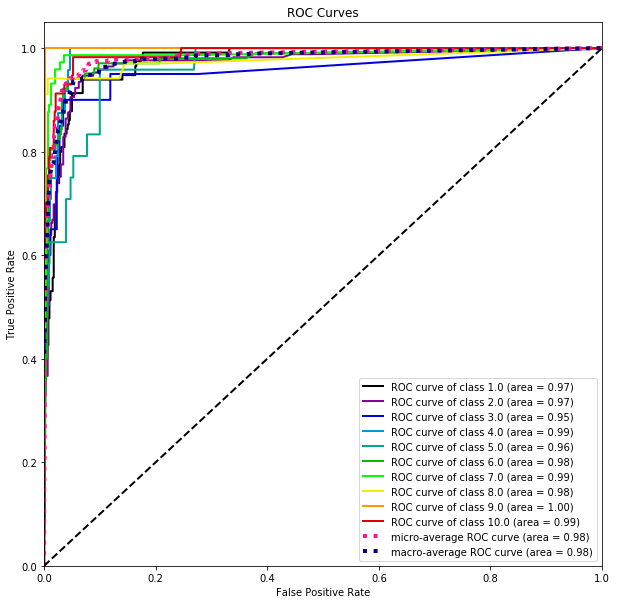

In [37]:
best_grid.fit(X_train, y_train_class)
class_pred = best_grid.predict(X_test)
print(f'Random Forest:\nClass\n{metrics.classification_report(y_test_class, class_pred)}\n')
print(f'confusion matrix: \n {confusion_matrix(y_test_class, class_pred)}')
indx.append('test data class recall')
cv.append(metrics.recall_score(y_test_class, class_pred, average='macro', zero_division=1))
stds.append('NaN')
predicted_probas = best_grid.predict_proba(X_test)
skplt.metrics.plot_roc(y_test_class, predicted_probas, figsize=(10,10))
plt.show()
plt.close()


The Random forest model proved to be the best at predicting fetal heart rate patterns (CLASS), after tuning the macro recall of the test data was improved around 5% for ~77% to ~82%. This is important because any error in predicting fetal heart rate pattern will compound in the chain classifier prediction of fetal state.

### Chain Classifier using tuned random forest model

The first model in my chain classifier is now tuned. Using this model, class values are predicted for the test data. All five models will now be tested as the second classifier in the chain. These models will be crossvalidated using K Folds cross validation. These models will only be crossvalidated on the training data, so that a portion of the data remains completely unseen by the models. The models are then tested on the unseen test data, and the test recall value is compared to the recall of the cross validated model to measure validity.

In [38]:
#change sampling for NSP
oversample= SMOTE(sampling_strategy={2.0:400, 3.0:400}, random_state=13)
undersample = RandomUnderSampler(sampling_strategy={1:800}, random_state=13)

In [39]:
#using model trained on oversampled data, predict the class for the chain classifier

#column names and order
col = X_train.columns
dummy_col = ctg_data.loc[:,'LB':"SUSP"].columns

#predicted test class, and actual train class
test_class = class_pred
train_class = y_train_class
#The data has their dummy variable as '-1' for 'no' and '1' for yes, swapping to '0' for no for consistency

test_dummies = pd.get_dummies(test_class).rename(columns={1.0:'A', 2.0:'B', 3.0:'C', 4.0:'D', 5.0:'E', 6.0:'AD',
                                                                 7.0:'DE', 8.0:'LD', 9.0:'FS', 10.0:'SUSP'})

train_dummies = pd.get_dummies(train_class).rename(columns={1.0:'A', 2.0:'B', 3.0:'C', 4.0:'D', 5.0:'E', 6.0:'AD',
                                                                 7.0:'DE', 8.0:'LD', 9.0:'FS', 10.0:'SUSP'})

X_test3 = pd.concat([X_test.reset_index(drop=True), test_dummies], axis=1)
X_test3 = X_test3[dummy_col]
X_train3 = pd.concat([X_train.reset_index(drop=True), train_dummies], axis=1)
X_train3 = X_train3[dummy_col]


In [40]:
#chain classifier cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=13)

models = [('Support Vector Machine', svm.SVC(kernel='linear')), 
          ('Logistic Regression', LogisticRegression(solver='newton-cg',n_jobs=-1)), 
          ('K-Nearest Neighbors', KNeighborsClassifier(weights='distance')),
          ('Decision Tree', tree.DecisionTreeClassifier(random_state=13)), 
          ('Random Forest', RandomForestClassifier(random_state=13, n_estimators=100))]

#loop through the models
mean = []
std = []
classifier = []
for clf, model in models:
    classifier.append(clf)
    pipe = Pipeline([('rscale', rob_scale), ('os', oversample), ('us', undersample),('rfe', rfe), ('clf', model)])
    score = cross_val_score(pipe, X_train3, y_train_nsp, scoring='recall_macro', cv=kf, n_jobs=-1)
    mean.append(score.mean())
    std.append(score.std())
    print(clf + ':')
    print(f'recall: {score.mean()}')
    y_pred_smote = cross_val_predict(pipe, X_train3, y_train_nsp, cv=kf, n_jobs=-1)
    print(f'confusion matrix \n{confusion_matrix(y_train_nsp, y_pred_smote)}\n')
    
#dataframe for easy viewing
smote_chain_cv = pd.DataFrame({'CV Recall Mean':mean, 'Std':std}, index=classifier)
display(smote_chain_cv)

Support Vector Machine:
recall: 0.9648718832378723
confusion matrix 
[[1148    5    0]
 [  19  184    1]
 [   0    0  123]]

Logistic Regression:
recall: 0.973241432542812
confusion matrix 
[[1147    6    0]
 [  14  189    1]
 [   0    0  123]]

K-Nearest Neighbors:
recall: 0.9508967225600868
confusion matrix 
[[1140   10    3]
 [  15  188    1]
 [   5    1  117]]

Decision Tree:
recall: 0.9599496183925081
confusion matrix 
[[1137   16    0]
 [  17  186    1]
 [   0    1  122]]

Random Forest:
recall: 0.9687518698230997
confusion matrix 
[[1149    4    0]
 [  15  188    1]
 [   1    0  122]]



CV Recall Mean       Std
Support Vector Machine        0.964872  0.023554
Logistic Regression           0.973241  0.021105
K-Nearest Neighbors           0.950897  0.019927
Decision Tree                 0.959950  0.020265
Random Forest                 0.968752  0.025871

Those are good scores, unfortunately these models have not seen the predicted fetal heart rate pattern data, only the true fetal heart rate pattern data. Since all five models scored really well I will test all five as the final part of my chain classifier.

Support Vector Machine:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       495
         2.0       0.76      0.80      0.78        88
         3.0       0.91      0.94      0.92        52

    accuracy                           0.93       635
   macro avg       0.88      0.90      0.89       635
weighted avg       0.93      0.93      0.93       635

confusion matrix 
[[469  22   4]
 [ 17  70   1]
 [  3   0  49]]



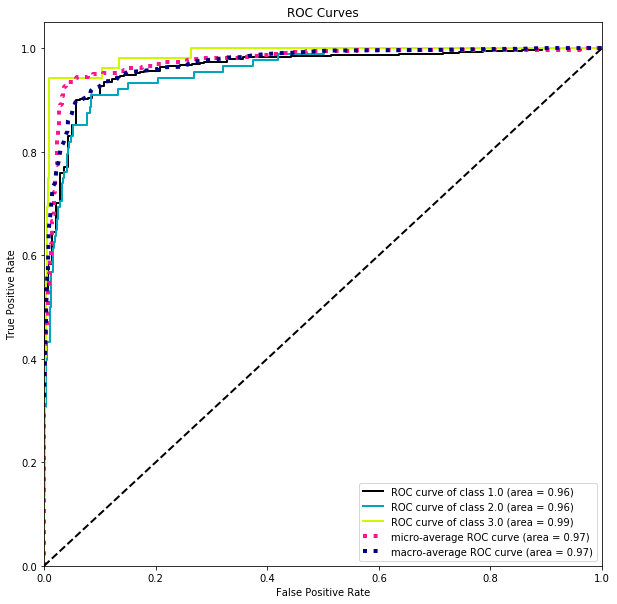

Logistic Regression:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       495
         2.0       0.75      0.80      0.77        88
         3.0       0.91      0.94      0.92        52

    accuracy                           0.92       635
   macro avg       0.87      0.89      0.88       635
weighted avg       0.93      0.92      0.93       635

confusion matrix 
[[468  23   4]
 [ 17  70   1]
 [  3   0  49]]



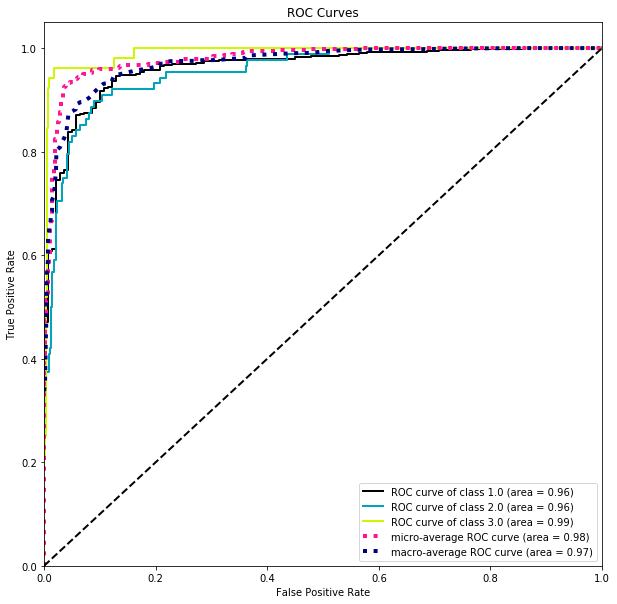

K-Nearest Neighbors:
              precision    recall  f1-score   support

         1.0       0.96      0.94      0.95       495
         2.0       0.75      0.81      0.78        88
         3.0       0.88      0.94      0.91        52

    accuracy                           0.92       635
   macro avg       0.86      0.90      0.88       635
weighted avg       0.93      0.92      0.92       635

confusion matrix 
[[466  24   5]
 [ 15  71   2]
 [  3   0  49]]



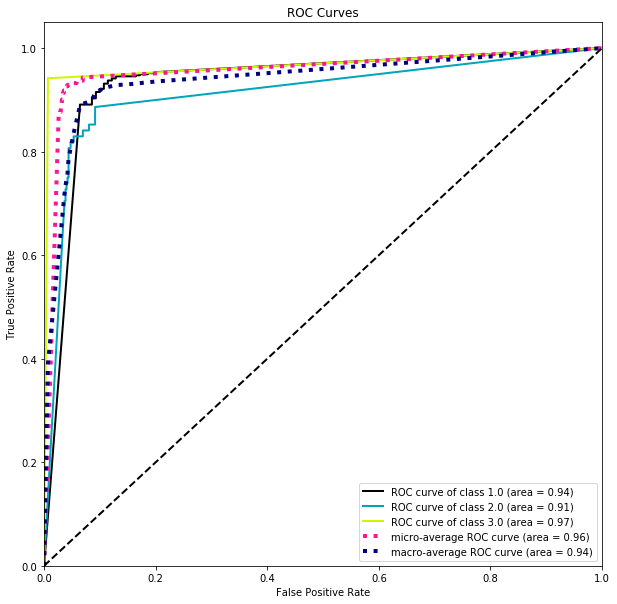

Decision Tree:
              precision    recall  f1-score   support

         1.0       0.95      0.93      0.94       495
         2.0       0.67      0.75      0.71        88
         3.0       0.91      0.94      0.92        52

    accuracy                           0.90       635
   macro avg       0.84      0.87      0.86       635
weighted avg       0.91      0.90      0.91       635

confusion matrix 
[[459  32   4]
 [ 21  66   1]
 [  3   0  49]]



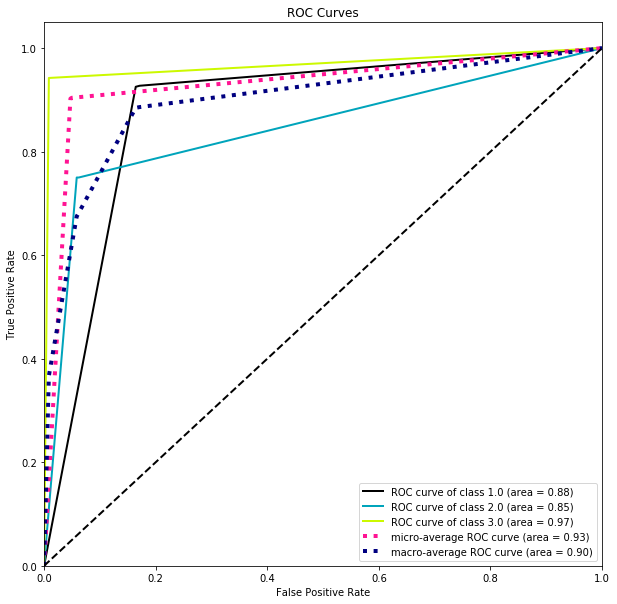

Random Forest:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       495
         2.0       0.76      0.80      0.78        88
         3.0       0.91      0.94      0.92        52

    accuracy                           0.93       635
   macro avg       0.88      0.90      0.89       635
weighted avg       0.93      0.93      0.93       635

confusion matrix 
[[469  22   4]
 [ 17  70   1]
 [  3   0  49]]



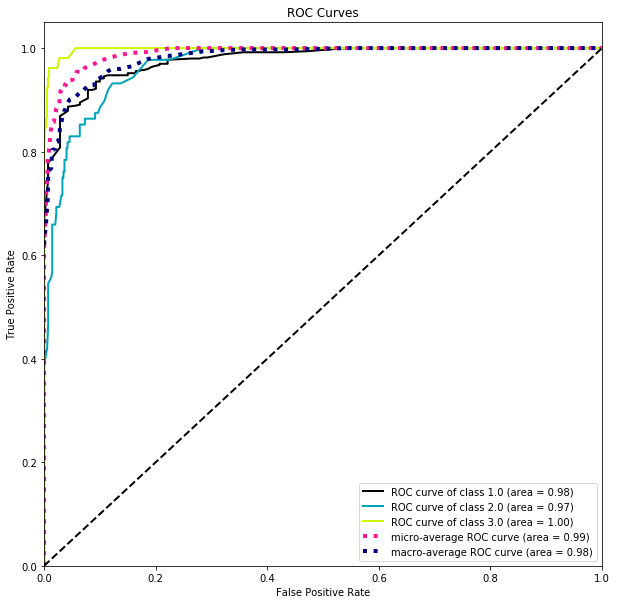

CV Recall Mean       Std  chain_recall
Support Vector Machine        0.964872  0.023554      0.895079
Logistic Regression           0.973241  0.021105      0.894406
K-Nearest Neighbors           0.950897  0.019927      0.896847
Decision Tree                 0.959950  0.020265      0.873193
Random Forest                 0.968752  0.025871      0.895079

In [41]:
#chain classifier all models
models = [('Support Vector Machine', svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr', break_ties=True)), 
          ('Logistic Regression', LogisticRegression(solver='newton-cg',n_jobs=-1)), 
          ('K-Nearest Neighbors', KNeighborsClassifier(weights='distance')),
          ('Decision Tree', tree.DecisionTreeClassifier(random_state=13)), 
          ('Random Forest', RandomForestClassifier(random_state=13, n_estimators=100))]

#loop the models
recall = []
for clf, model in models:
    pipe = Pipeline([('rscale', rob_scale), ('os', oversample), ('us', undersample),('rfe', rfe), ('clf', model)])
    pipe.fit(X_train3, y_train_nsp)
    chain_pred = pipe.predict(X_test3)
    print(clf + ':')
    print(classification_report(y_test_nsp, chain_pred))
    print(f'confusion matrix \n{confusion_matrix(y_test_nsp, chain_pred)}\n')
    recall.append(metrics.recall_score(y_test_nsp, chain_pred, average='macro', zero_division=1))
    predicted_probas = pipe.predict_proba(X_test3)
    skplt.metrics.plot_roc(y_test_nsp, predicted_probas, figsize=(10,10))
    plt.show()
    plt.close()
#dataFrame for easy viewing                 
smote_chain_cv['chain_recall'] = recall
display(smote_chain_cv)


Four models have ~90% recall. Since Random Forest had the best recall when used as the final classifier in the baseline chain classifier, I will attempt to tune this model further.

In [42]:
#cross validate results for random forest class model
kf = KFold(n_splits=10, shuffle=True, random_state=13)


indx.append('k folds chain mean recall')

#feature selection
rf= RandomForestClassifier(random_state=13)
rfe = RFE(rf, n_features_to_select=15)

pipe = Pipeline([('rscale', rob_scale), ('os', oversample), ('us', undersample), ('rfe', rfe),
                 ('rf', RandomForestClassifier(random_state=13, n_estimators=100))])
#cross validation
score = cross_val_score(pipe, X_train3, y_train_nsp, scoring='recall_macro', cv=kf)
cv.append(score.mean())
stds.append(score.std())
print(clf + ':')
print(f'k folds (k=10) mean recall: {score.mean()}')
chain_pred = cross_val_predict(pipe, X_train3, y_train_nsp, cv=kf)
print(f'confusion matrix \n{confusion_matrix(y_train_nsp, chain_pred)}\n')

Random Forest:
k folds (k=10) mean recall: 0.9687518698230997
confusion matrix 
[[1149    4    0]
 [  15  188    1]
 [   1    0  122]]



The random forest model can predict fetal state with ~97% recall when provided actual fetal heart rate pattern values.

Hyperparameter tuning and feature elimination are performed to try to get the fetal state prediction recall that high when the model is used to predict the test data.

In [43]:
#feature selection
rf= RandomForestClassifier(random_state=13)
rfe = RFE(rf, n_features_to_select=15)

pipe = Pipeline([('rscale', rob_scale), ('os', oversample), ('us', undersample), ('rfe', rfe),
                 ('rf', RandomForestClassifier(random_state=13))])

#hyperparameter tuning
params = {
    'rf__bootstrap': [True, False],
    'rf__max_depth': [50, 60 ,70, 80, 90],
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__min_samples_leaf': [3, 4, 5],
    'rf__min_samples_split': [2, 3, 4, 5],
    'rf__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]}

grid_search = GridSearchCV(estimator = pipe, param_grid = params, 
                          scoring='recall_macro', refit=True, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train3, y_train_nsp)
display(grid_search.best_params_ )
best_grid=grid_search.best_estimator_


Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


C:\Users\Nyall\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]



{'rf__bootstrap': True,
 'rf__max_depth': 50,
 'rf__max_features': None,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100}

Random Forest:
Class
              precision    recall  f1-score   support

         1.0       0.96      0.94      0.95       495
         2.0       0.71      0.78      0.75        88
         3.0       0.91      0.94      0.92        52

    accuracy                           0.92       635
   macro avg       0.86      0.89      0.87       635
weighted avg       0.92      0.92      0.92       635


confusion matrix: 
 [[465  26   4]
 [ 18  69   1]
 [  1   2  49]]


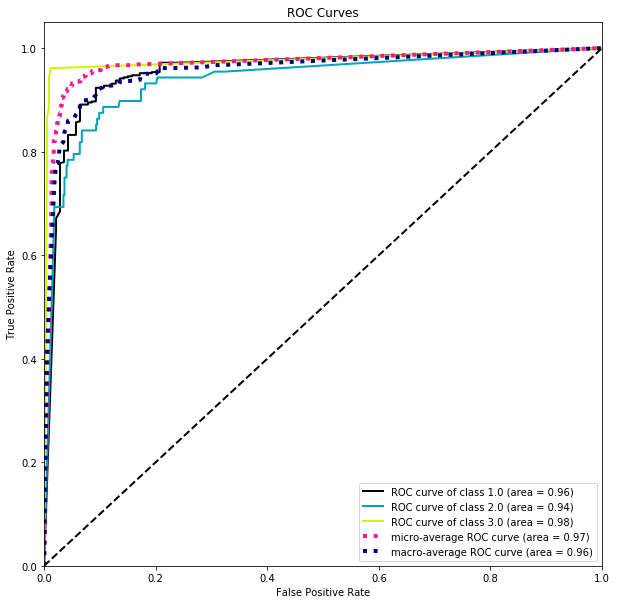

In [44]:
#best hyperparameter model is used to predict NSP
best_grid.fit(X_train3, y_train_nsp)
chain_pred = best_grid.predict(X_test3)
print(f'Random Forest:\nClass\n{metrics.classification_report(y_test_nsp, chain_pred)}\n')
print(f'confusion matrix: \n {confusion_matrix(y_test_nsp, chain_pred)}')
indx.append('test data nsp chain recall')
cv.append(metrics.recall_score(y_test_nsp, chain_pred, average='macro', zero_division=1))
stds.append('NaN')
predicted_probas = best_grid.predict_proba(X_test3)
skplt.metrics.plot_roc(y_test_nsp, predicted_probas, figsize=(10,10))
plt.show()
plt.close()

In [59]:
final_df = pd.DataFrame({'recall':cv, 'std':stds}, index=indx)
final_df.reset_index(inplace=True)
final_df['from'] = ['first classifier cross validation', 'first classifier cross validation', 'second classifier cross validation', 'second classifier cross validation']
final_df.set_index(['from', 'index'], inplace=True)
final_df = final_df.rename_axis(index={'from': 'Step in Chain Classifier', 'index': ' '})
final_df

recall  \
Step in Chain Classifier                                                  
first classifier cross validation  k folds class mean recall   0.848841   
                                   test data class recall      0.817593   
second classifier cross validation k folds chain mean recall   0.968752   
                                   test data nsp chain recall  0.888598   

                                                                     std  
Step in Chain Classifier                                                  
first classifier cross validation  k folds class mean recall   0.0626212  
                                   test data class recall            NaN  
second classifier cross validation k folds chain mean recall   0.0258713  
                                   test data nsp chain recall        NaN

The test data class recall is very close to the cross validated mean recall, this result is most likely valid. The test data NSP recall was not that close to the cross validated NSP recall of the second classifier in the chain classifier. This is most likely due to the test data having fetal heart rate states predicted from another model. The ~89% recall obtained after tuning the second random forest classifier in the classifier chain is very close to the recall of the classifer chain with the first random forest classifier tuned and the second random forest classifier untuned. This leads me to believe that the second random forest classifier is already near optimal and the only way to improve it further would be to improve the first classifier, thus reducing false labels being used to predict the next label.

In [60]:
print('Model Selection')
display(model_select)
print('\n'*2)
print('Chain Classifier Cross Validation')
print('First Classifier tuned, Second Classifier Validation')
display(smote_chain_cv)
print('\n'*2)
print('Chain Classifier Cross Validation')
print('')
display(final_df)

Model Selection


nsp_recall  class_recall  chain_recall
Support Vector Machine    0.828645      0.747739      0.869483
Logistic Regression       0.805245      0.718962      0.868810
K-Nearest Neighbors       0.779235      0.657679      0.840948
Decision Tree             0.900648      0.758977      0.854753
Random Forest             0.862801      0.769524      0.868810




Chain Classifier Cross Validation
First Classifier tuned, Second Classifier Validation


CV Recall Mean       Std  chain_recall
Support Vector Machine        0.964872  0.023554      0.895079
Logistic Regression           0.973241  0.021105      0.894406
K-Nearest Neighbors           0.950897  0.019927      0.896847
Decision Tree                 0.959950  0.020265      0.873193
Random Forest                 0.968752  0.025871      0.895079




Chain Classifier Cross Validation



recall  \
Step in Chain Classifier                                                  
first classifier cross validation  k folds class mean recall   0.848841   
                                   test data class recall      0.817593   
second classifier cross validation k folds chain mean recall   0.968752   
                                   test data nsp chain recall  0.888598   

                                                                     std  
Step in Chain Classifier                                                  
first classifier cross validation  k folds class mean recall   0.0626212  
                                   test data class recall            NaN  
second classifier cross validation k folds chain mean recall   0.0258713  
                                   test data nsp chain recall        NaN

After tuning both classifiers in the classification chain it appears that the random forest classifier has peaked at around 90% recall. Without finding a way to more accurately predict CLASS I believe that this is about as accurate as I can get the chain classifier. However when the chain classifier is cross validated on the data containing the actual CLASS values, Logistic REgression and Random Forest Classifiers both had recall of ~97%. This leads me to believe that if a model that more accurately predicted class were generated, a chain classifier with recall approaching 97% could be generated.